In [1]:
import tsai
from tsai.all import *
print('tsai       :', tsai.__version__)
print('fastai     :', fastai.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)

C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.JPIJNSWNNAN3CE6LLI5FWSPHUT2VXMTH.gfortran-win_amd64.dll
C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


tsai       : 0.2.15
fastai     : 2.2.5
fastcore   : 1.3.19
torch      : 1.7.1+cu101


# 0. load data

In [2]:
input_fn = 'F:\\Github\\kaggle drought\\data_ndarray.npz'

In [3]:
data = np.load(open(input_fn, 'rb'))

In [4]:
X_train = data['X_train']

In [5]:
X_train.shape

(118024, 90, 18)

In [6]:
print(np.mean(X_train.flatten()))

1.1619668e-07


In [7]:
print(np.std(X_train.flatten()))

1.0000005


In [8]:
X_valid = data['X_valid']

In [9]:
X_test = data['X_test']

In [10]:
y_train = data['y_train']
y_train = np.array([int(i) for i in y_train])

In [11]:
y_valid = data['y_valid']
y_valid = np.array([int(i) for i in y_valid])

In [12]:
y_test = data['y_test']
y_test = np.array([int(i) for i in y_test])

We need to exchange two axes：
* **number of samples**
* **number of features** (aka variables, dimensions, channels)
* **number of steps** (or length, time steps, sequence steps)

In [13]:
X_train = X_train.transpose(0, 2, 1)
X_train.shape

(118024, 18, 90)

In [14]:
X_valid = X_valid.transpose(0, 2, 1)
X_valid.shape

(20721, 18, 90)

In [15]:
X_test = X_test.transpose(0, 2, 1)
X_test.shape

(102430, 18, 90)

We already have the split:

In [16]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [17]:
X.shape

(138745, 18, 90)

In [18]:
y.shape

(138745,)

In [19]:
splits

((#118024) [0,1,2,3,4,5,6,7,8,9...],
 (#20721) [118024,118025,118026,118027,118028,118029,118030,118031,118032,118033...])

In [20]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dsets

(#138745) [(TSTensor(vars:18, len:90), TensorCategory(2, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(1, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(2, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(1, dtype=torch.int32))...]

# 1. Model and Hyperparameter Tuning

In [21]:
import hyperopt
print(hyperopt.__version__)

0.2.5


In [22]:
from hyperopt import Trials, STATUS_OK, STATUS_FAIL, tpe, fmin, hp

In [23]:
search_space = {
    'batch_size': hp.choice('bs', [256, 512, 1024]),
    'time_steps': hp.choice('ts', [30, 60, 90]),  # lookback window size
    "lr": hp.choice('lr', [0.1, 0.01, 0.001, 0.0001]),
    "epochs": hp.choice('epochs', [10, 50, 100]),  # we would also use early stopping
    "patience": hp.choice('patience', [5, 10]),  # early stopping patience
    "optimizer": hp.choice('optimizer', [Adam, SGD, RMSProp]),  # https://docs.fast.ai/optimizer
    # model parameters
    "rnn_layers": hp.choice('rnn_layers', [1, 2, 3, 4, 5]),
    "hidden_size": hp.choice('hidden_size', [50, 100, 200]),
    "bidirectional": hp.choice('bidirectional', [True, False]),
    "conv_layers": hp.choice('conv_layers', [[64, 128, 64], [128, 256, 128], [256, 512, 256]]),
    "kss": hp.choice('kss', [[11, 9, 7], [9, 7, 5], [7, 5, 3]])
}

In [24]:
search_space

{'batch_size': <hyperopt.pyll.base.Apply at 0x1897b609848>,
 'time_steps': <hyperopt.pyll.base.Apply at 0x1897b609e88>,
 'lr': <hyperopt.pyll.base.Apply at 0x1897b605608>,
 'epochs': <hyperopt.pyll.base.Apply at 0x1897b605c08>,
 'patience': <hyperopt.pyll.base.Apply at 0x1897b5f71c8>,
 'optimizer': <hyperopt.pyll.base.Apply at 0x1897b5f77c8>,
 'rnn_layers': <hyperopt.pyll.base.Apply at 0x1897b5fa048>,
 'hidden_size': <hyperopt.pyll.base.Apply at 0x1897b5fa5c8>,
 'bidirectional': <hyperopt.pyll.base.Apply at 0x1897b5fab48>,
 'conv_layers': <hyperopt.pyll.base.Apply at 0x1897b60b908>,
 'kss': <hyperopt.pyll.base.Apply at 0x1897b601648>}

In [25]:
X.shape

(138745, 18, 90)

In [26]:
time_steps = 30

In [27]:
X[:, :, -time_steps:].shape

(138745, 18, 30)

In [28]:
X_test[:, :, -time_steps:].shape

(102430, 18, 30)

In [29]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [30]:
import time
from fastai.callback.tracker import EarlyStoppingCallback

In [31]:
import gc

In [32]:
# clear memory 
gc.collect()

183

In [33]:
def create_model_hypopt(params):
    
    try:
        # clear memory 
        gc.collect()
        print("Trying params:",params)
        batch_size = params["batch_size"]
        time_steps = params["time_steps"]
    
        # Create data loader
        tfms  = [None, [Categorize()]]
        dsets = TSDatasets(X[:, :, -time_steps:], y, tfms=tfms, splits=splits, inplace=True)
        # set num_workers for memory bottleneck
        dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)
    
        # Create model
        arch = GRU_FCN
        k = {
            'rnn_layers': params['rnn_layers'],
            'hidden_size': params['hidden_size'],
            'bidirectional': params['bidirectional'],
            'conv_layers': params['conv_layers'],
            'kss': params['kss']
        }
        model = create_model(arch, dls=dls, **k)
        print(model.__class__.__name__)
    
        # Training the model
        learn = Learner(dls, model, metrics=accuracy, opt_func=params['optimizer'])
        start = time.time()
        learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                            cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
        learn.plot_metrics()
        elapsed = time.time() - start
    
        vals = learn.recorder.values[-1]
        # vals[0], vals[1], vals[2]
        # train loss, valid loss, accuracy
        val_loss = vals[1]
    
        # delete tmp variables
        del dls
        del model
        del learn
        return {'loss': val_loss, 'status': STATUS_OK} # if accuracy use '-' sign, model is optional
    except:
        return {'loss': None, 'status': STATUS_FAIL}

Search the parameters:

Trying params:                                                                                                         
{'batch_size': 512, 'bidirectional': True, 'conv_layers': (256, 512, 256), 'epochs': 50, 'hidden_size': 200, 'kss': (9, 7, 5), 'lr': 0.1, 'optimizer': <function RMSProp at 0x00000188DE20C1F8>, 'patience': 5, 'rnn_layers': 2, 'time_steps': 30}
GRU_FCN                                                                                                                
  0%|                                                                           | 0/30 [00:28<?, ?trial/s, best loss=?]

epoch,train_loss,valid_loss,accuracy,time
0,0.989983,0.986043,0.635104,00:11
1,0.981930,1.012039,0.672024,00:10
2,0.968450,1.081713,0.666039,00:10
3,1.019486,1.216748,0.664784,00:10
4,1.125975,1.447737,0.651706,00:10
5,3.280757,28.924494,0.662130,00:10


No improvement since epoch 0: early stopping                                                                           
  0%|                                                                           | 0/30 [01:32<?, ?trial/s, best loss=?]

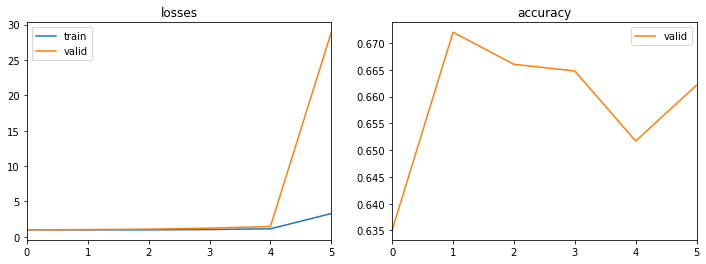

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': False, 'conv_layers': (256, 512, 256), 'epochs': 50, 'hidden_size': 100, 'kss': (11, 9, 7), 'lr': 0.1, 'optimizer': <function RMSProp at 0x00000188DE20C1F8>, 'patience': 10, 'rnn_layers': 5, 'time_steps': 90}
GRU_FCN                                                                                                                
  3%|█▋                                                | 1/30 [01:58<44:36, 92.30s/trial, best loss: 28.92449378967285]

epoch,train_loss,valid_loss,accuracy,time
0,0.975770,0.890846,0.665653,00:18
1,0.934653,0.913819,0.665798,00:17
2,0.913768,0.893206,0.687129,00:18
3,0.897307,0.968695,0.632981,00:18
4,0.897734,0.947743,0.677091,00:18
5,0.892491,1.154252,0.674919,00:18
6,0.863765,1.112555,0.668259,00:18
7,0.904812,1.348691,0.665798,00:18
8,0.937401,2.986546,0.269726,00:18
9,0.914268,0.947742,0.649486,00:18


No improvement since epoch 0: early stopping                                                                           
  3%|█▋                                                | 1/30 [05:18<44:36, 92.30s/trial, best loss: 28.92449378967285]

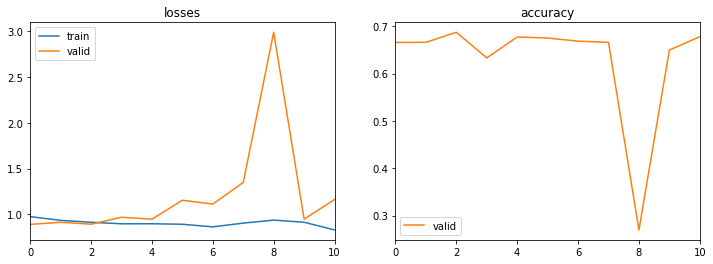

Trying params:                                                                                                         
{'batch_size': 512, 'bidirectional': True, 'conv_layers': (64, 128, 64), 'epochs': 100, 'hidden_size': 100, 'kss': (7, 5, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x00000188DE20C438>, 'patience': 5, 'rnn_layers': 2, 'time_steps': 30}
GRU_FCN                                                                                                                
  7%|███▏                                           | 2/30 [05:44<1:01:54, 132.65s/trial, best loss: 1.162397861480713]

epoch,train_loss,valid_loss,accuracy,time
0,0.967747,1.003469,0.660634,00:04
1,0.921442,0.954426,0.670769,00:03
2,0.890922,0.928636,0.673230,00:03
3,0.874089,0.961380,0.669562,00:03
4,0.847461,0.925373,0.672410,00:03
5,0.834034,1.048636,0.667584,00:03
6,0.798004,1.002643,0.672120,00:03
7,0.768806,1.162158,0.665991,00:03
8,0.753922,1.121434,0.649969,00:03
9,0.717740,1.111009,0.656049,00:03


No improvement since epoch 4: early stopping                                                                           
  7%|███▏                                           | 2/30 [06:23<1:01:54, 132.65s/trial, best loss: 1.162397861480713]

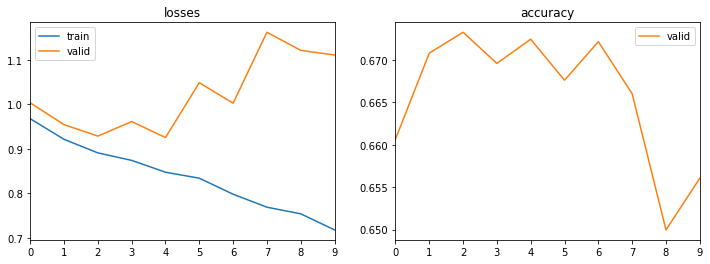

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': False, 'conv_layers': (128, 256, 128), 'epochs': 100, 'hidden_size': 100, 'kss': (7, 5, 3), 'lr': 0.01, 'optimizer': <function RMSProp at 0x00000188DE20C1F8>, 'patience': 10, 'rnn_layers': 1, 'time_steps': 90}
GRU_FCN                                                                                                                
 10%|████▊                                           | 3/30 [06:49<50:34, 112.37s/trial, best loss: 1.1110087633132935]

epoch,train_loss,valid_loss,accuracy,time
0,0.934272,0.903542,0.668838,00:05
1,0.879893,0.889645,0.676560,00:05
2,0.851449,0.879187,0.684378,00:05
3,0.837153,0.854827,0.683365,00:05
4,0.820810,0.877286,0.681531,00:05
5,0.809617,1.071602,0.584673,00:05
6,0.801316,1.013326,0.640027,00:05
7,0.786779,1.176670,0.599344,00:05
8,0.776959,0.896578,0.672796,00:05
9,0.753548,0.889323,0.683606,00:05


No improvement since epoch 3: early stopping                                                                           
 10%|████▊                                           | 3/30 [08:05<50:34, 112.37s/trial, best loss: 1.1110087633132935]

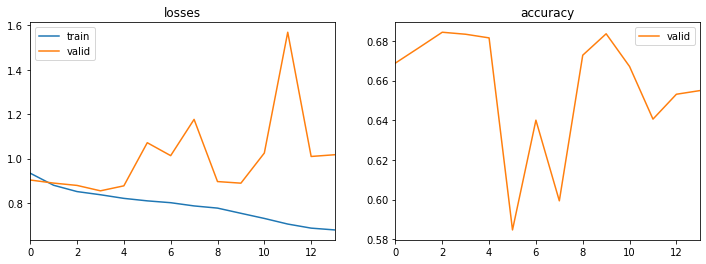

Trying params:                                                                                                         
{'batch_size': 512, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 10, 'hidden_size': 50, 'kss': (7, 5, 3), 'lr': 0.1, 'optimizer': <function Adam at 0x00000188DE20C438>, 'patience': 5, 'rnn_layers': 5, 'time_steps': 30}
GRU_FCN                                                                                                                
 13%|██████▍                                         | 4/30 [08:31<47:17, 109.15s/trial, best loss: 1.0173792839050293]

epoch,train_loss,valid_loss,accuracy,time
0,0.961838,0.992776,0.667342,00:07
1,0.958198,0.913206,0.681193,00:06
2,0.949687,1.096699,0.659235,00:06
3,0.888358,1.026508,0.669031,00:06
4,0.840863,1.172315,0.673230,00:06
5,0.765934,1.150498,0.649824,00:06
6,0.675715,1.269598,0.657256,00:06


No improvement since epoch 1: early stopping                                                                           
 13%|██████▍                                         | 4/30 [09:19<47:17, 109.15s/trial, best loss: 1.0173792839050293]

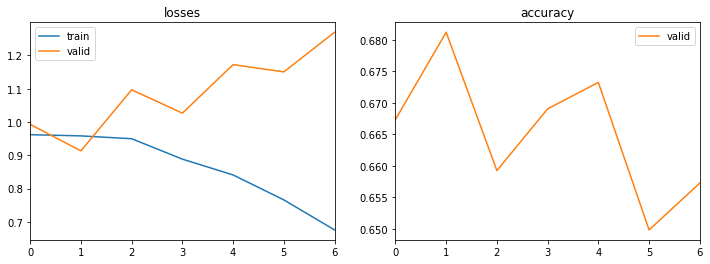

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': False, 'conv_layers': (128, 256, 128), 'epochs': 50, 'hidden_size': 50, 'kss': (7, 5, 3), 'lr': 0.0001, 'optimizer': <function RMSProp at 0x00000188DE20C1F8>, 'patience': 10, 'rnn_layers': 2, 'time_steps': 90}
GRU_FCN                                                                                                                
 17%|████████▏                                        | 5/30 [09:45<41:06, 98.66s/trial, best loss: 1.0173792839050293]

epoch,train_loss,valid_loss,accuracy,time
0,1.618212,1.631075,0.537619,00:06
1,1.396674,1.406650,0.580377,00:06
2,1.161069,1.133909,0.632885,00:06
3,1.000249,0.985372,0.655229,00:06
4,0.937658,0.938050,0.661792,00:06
5,0.895907,0.929110,0.667535,00:06
6,0.872941,0.890718,0.675691,00:06
7,0.857202,0.864219,0.683992,00:06
8,0.838934,0.868980,0.679890,00:06
9,0.819766,0.861861,0.685681,00:06


No improvement since epoch 13: early stopping                                                                          
 17%|████████▏                                        | 5/30 [12:28<41:06, 98.66s/trial, best loss: 1.0173792839050293]

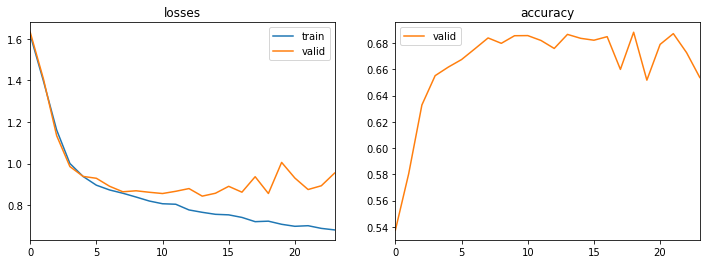

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': True, 'conv_layers': (64, 128, 64), 'epochs': 10, 'hidden_size': 100, 'kss': (11, 9, 7), 'lr': 0.01, 'optimizer': <function Adam at 0x00000188DE20C438>, 'patience': 5, 'rnn_layers': 2, 'time_steps': 60}
GRU_FCN                                                                                                                
 20%|█████████▊                                       | 6/30 [12:54<50:16, 125.68s/trial, best loss: 0.954062283039093]

epoch,train_loss,valid_loss,accuracy,time
0,0.890215,0.923598,0.680180,00:08
1,0.852747,1.016403,0.684040,00:08
2,0.759106,1.022171,0.664881,00:08
3,0.685344,1.122232,0.680759,00:08
4,0.604984,1.196238,0.658993,00:08
5,0.539082,1.333423,0.672072,00:08


No improvement since epoch 0: early stopping                                                                           
 20%|█████████▊                                       | 6/30 [13:42<50:16, 125.68s/trial, best loss: 0.954062283039093]

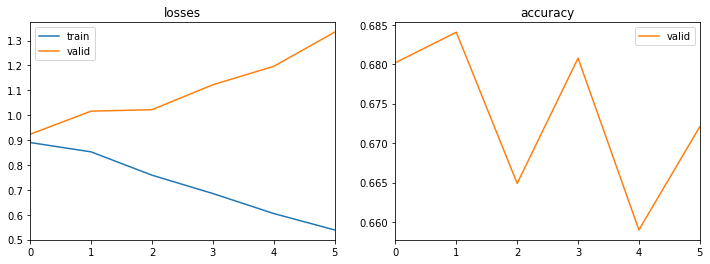

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': False, 'conv_layers': (256, 512, 256), 'epochs': 50, 'hidden_size': 50, 'kss': (7, 5, 3), 'lr': 0.001, 'optimizer': <function Adam at 0x00000188DE20C438>, 'patience': 5, 'rnn_layers': 2, 'time_steps': 90}
GRU_FCN                                                                                                                
 23%|███████████▍                                     | 7/30 [14:08<42:15, 110.22s/trial, best loss: 0.954062283039093]

epoch,train_loss,valid_loss,accuracy,time
0,0.935336,0.930410,0.664784,00:16
1,0.869669,0.868546,0.681627,00:16
2,0.821903,0.859109,0.683413,00:16
3,0.790025,0.862543,0.682593,00:16
4,0.753143,0.910428,0.676994,00:16
5,0.714992,1.049339,0.631726,00:16
6,0.683399,0.941539,0.685488,00:16
7,0.656654,1.217194,0.508325,00:16


No improvement since epoch 2: early stopping                                                                           
 23%|███████████▍                                     | 7/30 [16:21<42:15, 110.22s/trial, best loss: 0.954062283039093]

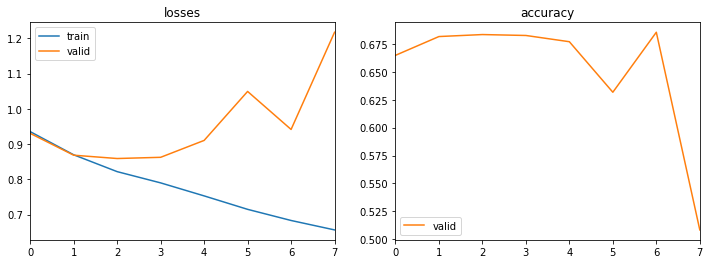

Trying params:                                                                                                         
{'batch_size': 512, 'bidirectional': True, 'conv_layers': (256, 512, 256), 'epochs': 10, 'hidden_size': 100, 'kss': (9, 7, 5), 'lr': 0.001, 'optimizer': <function Adam at 0x00000188DE20C438>, 'patience': 10, 'rnn_layers': 4, 'time_steps': 90}
GRU_FCN                                                                                                                
 27%|█████████████                                    | 8/30 [16:47<45:45, 124.80s/trial, best loss: 0.954062283039093]

epoch,train_loss,valid_loss,accuracy,time
0,0.939573,0.901811,0.667825,00:21
1,0.836564,0.929229,0.665991,00:20
2,0.751860,0.967221,0.647121,00:20
3,0.663481,1.114455,0.679600,00:21
4,0.586405,1.238691,0.657015,00:21
5,0.515888,1.043553,0.626418,00:21
6,0.451172,1.149629,0.671831,00:21
7,0.389375,1.677362,0.664398,00:21
8,0.352592,1.172788,0.641716,00:21
9,0.332325,1.286707,0.649003,00:21


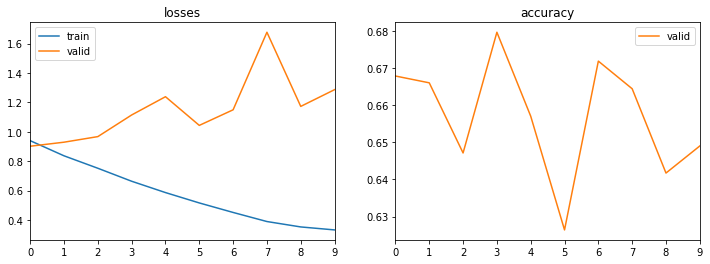

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': False, 'conv_layers': (64, 128, 64), 'epochs': 100, 'hidden_size': 50, 'kss': (9, 7, 5), 'lr': 0.001, 'optimizer': <function RMSProp at 0x00000188DE20C1F8>, 'patience': 10, 'rnn_layers': 1, 'time_steps': 90}
GRU_FCN                                                                                                                
 30%|██████████████▋                                  | 9/30 [20:43<55:25, 158.36s/trial, best loss: 0.954062283039093]

epoch,train_loss,valid_loss,accuracy,time
0,1.164802,1.127370,0.631581,00:04
1,0.998239,0.976921,0.657642,00:04
2,0.929764,0.938531,0.662372,00:04
3,0.889206,0.900847,0.677622,00:04
4,0.856393,0.926214,0.660393,00:04
5,0.827267,0.858369,0.683220,00:04
6,0.812770,1.053542,0.619034,00:04
7,0.808860,0.853175,0.688239,00:04
8,0.775707,0.843131,0.687660,00:04
9,0.785408,0.888504,0.684137,00:04


No improvement since epoch 8: early stopping                                                                           
 30%|██████████████▋                                  | 9/30 [22:08<55:25, 158.36s/trial, best loss: 0.954062283039093]

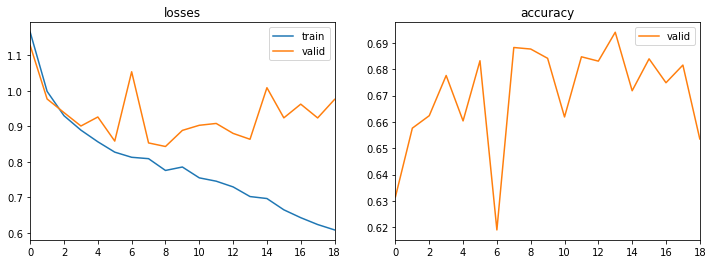

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': False, 'conv_layers': (256, 512, 256), 'epochs': 100, 'hidden_size': 100, 'kss': (11, 9, 7), 'lr': 0.001, 'optimizer': <function SGD at 0x00000188DE20C0D8>, 'patience': 5, 'rnn_layers': 2, 'time_steps': 90}
GRU_FCN                                                                                                                
 33%|████████████████                                | 10/30 [22:34<47:59, 143.96s/trial, best loss: 0.954062283039093]

epoch,train_loss,valid_loss,accuracy,time
0,1.603252,1.592172,0.632981,00:19
1,1.440979,1.421387,0.664398,00:19
2,1.318601,1.287300,0.664543,00:20
3,1.223963,1.200822,0.664543,00:19
4,1.168330,1.153987,0.664543,00:20
5,1.138613,1.128726,0.664543,00:20
6,1.114135,1.117199,0.664543,00:20
7,1.099171,1.107441,0.664543,00:20
8,1.077140,1.099919,0.664640,00:20
9,1.068003,1.091033,0.664543,00:20


No improvement since epoch 56: early stopping                                                                          
 33%|████████████████                                | 10/30 [44:15<47:59, 143.96s/trial, best loss: 0.954062283039093]

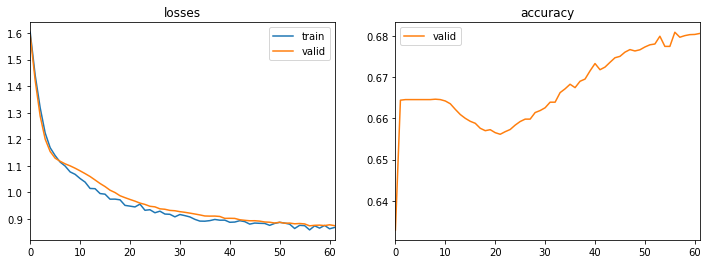

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': False, 'conv_layers': (128, 256, 128), 'epochs': 10, 'hidden_size': 100, 'kss': (7, 5, 3), 'lr': 0.1, 'optimizer': <function SGD at 0x00000188DE20C0D8>, 'patience': 5, 'rnn_layers': 1, 'time_steps': 30}
GRU_FCN                                                                                                                
 37%|████████████████▌                            | 11/30 [44:41<2:38:01, 499.02s/trial, best loss: 0.8747330904006958]

epoch,train_loss,valid_loss,accuracy,time
0,1.158917,1.071889,0.664495,00:02
1,1.008783,0.987873,0.657352,00:02
2,0.960881,0.982164,0.656242,00:02
3,0.943425,0.970667,0.661310,00:02
4,0.930572,0.967472,0.658897,00:02
5,0.923457,0.931850,0.671589,00:02
6,0.915868,0.932558,0.671831,00:02
7,0.911182,0.928276,0.673375,00:02
8,0.905564,0.932221,0.672024,00:02
9,0.906969,0.930458,0.672024,00:02


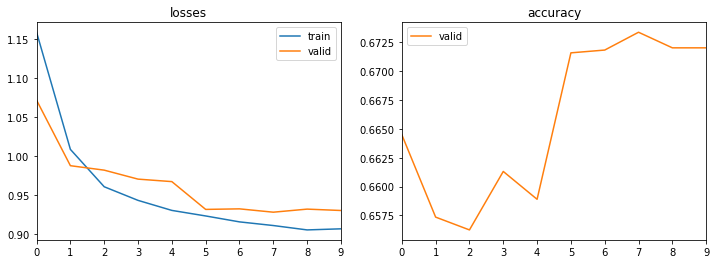

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 10, 'hidden_size': 50, 'kss': (11, 9, 7), 'lr': 0.1, 'optimizer': <function SGD at 0x00000188DE20C0D8>, 'patience': 5, 'rnn_layers': 2, 'time_steps': 30}
GRU_FCN                                                                                                                
 40%|██████████████████                           | 12/30 [45:32<1:49:20, 364.47s/trial, best loss: 0.8747330904006958]

epoch,train_loss,valid_loss,accuracy,time
0,0.994952,0.987770,0.656242,00:06
1,0.947421,1.000501,0.658076,00:05
2,0.915274,0.957012,0.666860,00:05
3,0.878407,0.915923,0.674630,00:05
4,0.866017,0.958121,0.666474,00:05
5,0.845483,0.925531,0.668790,00:05
6,0.815128,0.962853,0.662516,00:05
7,0.782982,0.933428,0.668114,00:05
8,0.772579,0.956015,0.669514,00:05


No improvement since epoch 3: early stopping                                                                           
 40%|██████████████████                           | 12/30 [46:23<1:49:20, 364.47s/trial, best loss: 0.8747330904006958]

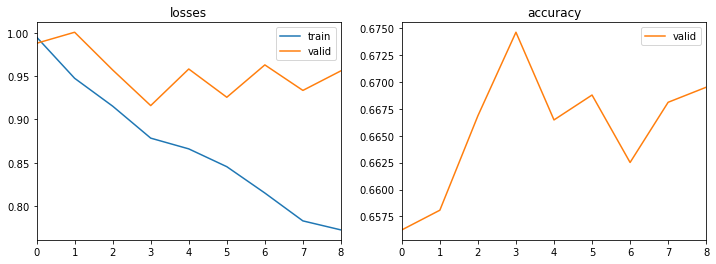

Trying params:                                                                                                         
{'batch_size': 512, 'bidirectional': True, 'conv_layers': (256, 512, 256), 'epochs': 10, 'hidden_size': 200, 'kss': (7, 5, 3), 'lr': 0.001, 'optimizer': <function Adam at 0x00000188DE20C438>, 'patience': 10, 'rnn_layers': 2, 'time_steps': 60}
GRU_FCN                                                                                                                
 43%|███████████████████▌                         | 13/30 [46:49<1:18:51, 278.30s/trial, best loss: 0.8747330904006958]

epoch,train_loss,valid_loss,accuracy,time
0,0.953406,0.909063,0.667246,00:14
1,0.865100,0.875377,0.684571,00:14
2,0.805515,0.977017,0.679166,00:14
3,0.730369,1.021217,0.672410,00:14
4,0.659281,1.084028,0.672989,00:14
5,0.586134,1.060575,0.618117,00:14
6,0.531977,1.172452,0.665171,00:14
7,0.475317,1.172440,0.661696,00:14
8,0.436602,1.166526,0.655905,00:15
9,0.423758,1.177968,0.652768,00:15


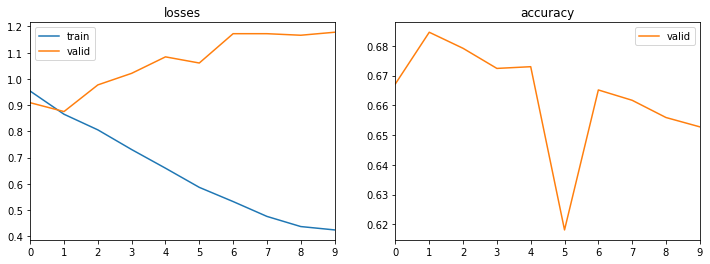

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': False, 'conv_layers': (64, 128, 64), 'epochs': 10, 'hidden_size': 50, 'kss': (9, 7, 5), 'lr': 0.1, 'optimizer': <function SGD at 0x00000188DE20C0D8>, 'patience': 10, 'rnn_layers': 2, 'time_steps': 90}
GRU_FCN                                                                                                                
 47%|█████████████████████                        | 14/30 [49:43<1:05:54, 247.13s/trial, best loss: 0.8747330904006958]

epoch,train_loss,valid_loss,accuracy,time
0,0.988592,0.987279,0.656773,00:04
1,0.902889,0.922498,0.673278,00:04
2,0.870378,0.878600,0.678780,00:04
3,0.844649,0.854609,0.684619,00:04
4,0.831193,0.858524,0.682641,00:04
5,0.799223,0.830714,0.689783,00:04
6,0.788505,0.877371,0.678201,00:04
7,0.767280,0.849520,0.684426,00:04
8,0.754710,0.843969,0.686405,00:04
9,0.757321,0.844987,0.685778,00:04


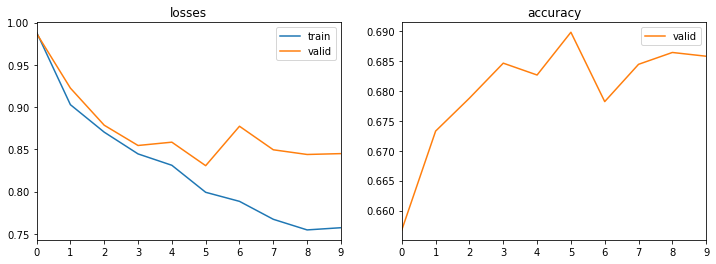

Trying params:                                                                                                         
{'batch_size': 512, 'bidirectional': True, 'conv_layers': (64, 128, 64), 'epochs': 50, 'hidden_size': 100, 'kss': (11, 9, 7), 'lr': 0.01, 'optimizer': <function Adam at 0x00000188DE20C438>, 'patience': 10, 'rnn_layers': 2, 'time_steps': 60}
GRU_FCN                                                                                                                
 50%|███████████████████████▌                       | 15/30 [50:55<48:38, 194.59s/trial, best loss: 0.8449867367744446]

epoch,train_loss,valid_loss,accuracy,time
0,0.929018,0.940776,0.673134,00:04
1,0.857210,0.921323,0.669031,00:04
2,0.807515,0.893908,0.685054,00:04
3,0.752586,1.009568,0.621881,00:04
4,0.713720,1.053633,0.674437,00:04
5,0.674654,1.058206,0.674388,00:04
6,0.640842,1.136347,0.650306,00:04
7,0.609067,1.095191,0.642585,00:04
8,0.583514,1.307394,0.580667,00:04
9,0.553559,1.285306,0.635394,00:04


No improvement since epoch 2: early stopping                                                                           
 50%|███████████████████████▌                       | 15/30 [51:49<48:38, 194.59s/trial, best loss: 0.8449867367744446]

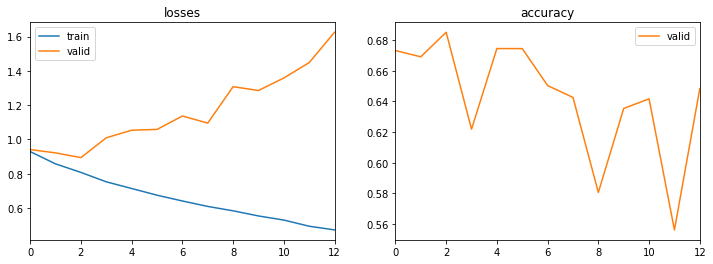

Trying params:                                                                                                         
{'batch_size': 512, 'bidirectional': True, 'conv_layers': (64, 128, 64), 'epochs': 50, 'hidden_size': 200, 'kss': (7, 5, 3), 'lr': 0.1, 'optimizer': <function RMSProp at 0x00000188DE20C1F8>, 'patience': 5, 'rnn_layers': 4, 'time_steps': 90}
GRU_FCN                                                                                                                
 53%|█████████████████████████                      | 16/30 [52:15<37:22, 160.16s/trial, best loss: 0.8449867367744446]

epoch,train_loss,valid_loss,accuracy,time
0,0.930424,0.900976,0.673713,00:11
1,0.907322,1.005276,0.631244,00:11
2,0.986767,0.905229,0.658028,00:11
3,1.087484,1.013260,0.653347,00:11
4,1.012992,0.978390,0.672651,00:11
5,2.522304,2.003089,0.491627,00:11


No improvement since epoch 0: early stopping                                                                           
 53%|█████████████████████████                      | 16/30 [53:23<37:22, 160.16s/trial, best loss: 0.8449867367744446]

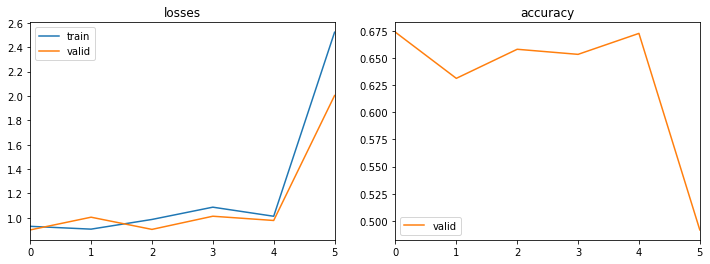

Trying params:                                                                                                         
{'batch_size': 512, 'bidirectional': False, 'conv_layers': (128, 256, 128), 'epochs': 50, 'hidden_size': 50, 'kss': (7, 5, 3), 'lr': 0.0001, 'optimizer': <function RMSProp at 0x00000188DE20C1F8>, 'patience': 5, 'rnn_layers': 3, 'time_steps': 90}
GRU_FCN                                                                                                                
 57%|██████████████████████████▋                    | 17/30 [53:49<30:23, 140.28s/trial, best loss: 0.8449867367744446]

epoch,train_loss,valid_loss,accuracy,time
0,1.829068,1.844558,0.326191,00:06
1,1.668748,1.717399,0.514744,00:05
2,1.459447,1.487873,0.572318,00:05
3,1.191490,1.136805,0.636456,00:06
4,1.014711,0.970915,0.653829,00:06
5,0.961591,0.940731,0.659572,00:06
6,0.924249,0.918081,0.669176,00:06
7,0.893309,0.899081,0.671782,00:06
8,0.866127,0.869789,0.680855,00:06
9,0.848647,0.855075,0.685536,00:06


No improvement since epoch 11: early stopping                                                                          
 57%|██████████████████████████▋                    | 17/30 [55:32<30:23, 140.28s/trial, best loss: 0.8449867367744446]

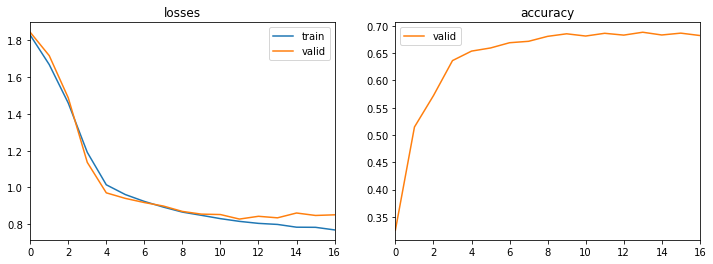

Trying params:                                                                                                         
{'batch_size': 512, 'bidirectional': True, 'conv_layers': (64, 128, 64), 'epochs': 50, 'hidden_size': 50, 'kss': (7, 5, 3), 'lr': 0.001, 'optimizer': <function SGD at 0x00000188DE20C0D8>, 'patience': 10, 'rnn_layers': 2, 'time_steps': 60}
GRU_FCN                                                                                                                
 60%|████████████████████████████▏                  | 18/30 [55:58<27:23, 136.96s/trial, best loss: 0.8449867367744446]

epoch,train_loss,valid_loss,accuracy,time
0,1.773040,1.756226,0.191159,00:03
1,1.725556,1.701015,0.305680,00:03
2,1.648762,1.612633,0.583997,00:03
3,1.537944,1.494999,0.664061,00:03
4,1.421860,1.372422,0.664543,00:03
5,1.318276,1.272462,0.664543,00:03
6,1.242491,1.206169,0.664543,00:03
7,1.205303,1.167509,0.664543,00:03
8,1.169230,1.144711,0.664543,00:03
9,1.151610,1.130586,0.664543,00:03


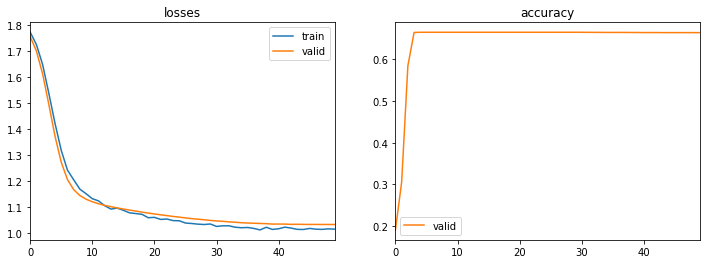

Trying params:                                                                                                         
{'batch_size': 512, 'bidirectional': False, 'conv_layers': (256, 512, 256), 'epochs': 100, 'hidden_size': 100, 'kss': (7, 5, 3), 'lr': 0.0001, 'optimizer': <function RMSProp at 0x00000188DE20C1F8>, 'patience': 5, 'rnn_layers': 1, 'time_steps': 90}
GRU_FCN                                                                                                                
 63%|█████████████████████████████▊                 | 19/30 [59:04<27:44, 151.32s/trial, best loss: 0.8449867367744446]

epoch,train_loss,valid_loss,accuracy,time
0,1.550969,1.587545,0.540080,00:15
1,1.411625,1.431004,0.574586,00:15
2,1.276989,1.282246,0.603880,00:15
3,1.155788,1.129753,0.638965,00:16
4,1.049103,1.038497,0.648473,00:16
5,0.978630,0.967284,0.660779,00:16
6,0.930733,0.930592,0.663337,00:16
7,0.909352,0.913882,0.668259,00:16
8,0.886676,0.895379,0.671927,00:16
9,0.865212,0.881272,0.672989,00:16


No improvement since epoch 13: early stopping                                                                          
 63%|████████████████████████████▌                | 19/30 [1:04:18<27:44, 151.32s/trial, best loss: 0.8449867367744446]

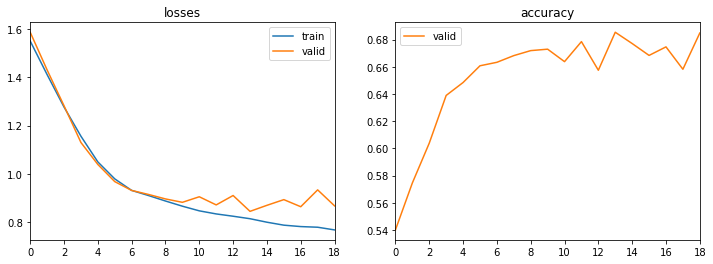

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': False, 'conv_layers': (128, 256, 128), 'epochs': 10, 'hidden_size': 50, 'kss': (9, 7, 5), 'lr': 0.0001, 'optimizer': <function SGD at 0x00000188DE20C0D8>, 'patience': 10, 'rnn_layers': 3, 'time_steps': 90}
GRU_FCN                                                                                                                
 67%|██████████████████████████████               | 20/30 [1:04:44<34:41, 208.11s/trial, best loss: 0.8449867367744446]

epoch,train_loss,valid_loss,accuracy,time
0,1.757896,1.732190,0.216544,00:08
1,1.617873,1.571494,0.659669,00:08
2,1.448618,1.404778,0.664543,00:08
3,1.347082,1.302915,0.664543,00:08
4,1.290253,1.246448,0.664543,00:08
5,1.250193,1.214152,0.664543,00:08
6,1.235526,1.196717,0.664543,00:08
7,1.220718,1.189887,0.664543,00:08
8,1.222616,1.186063,0.664543,00:08
9,1.217862,1.185519,0.664543,00:08


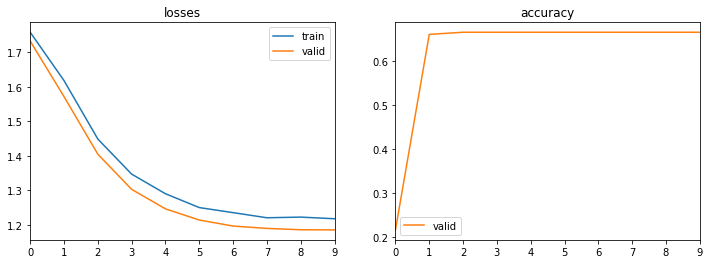

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': False, 'conv_layers': (128, 256, 128), 'epochs': 50, 'hidden_size': 50, 'kss': (9, 7, 5), 'lr': 0.0001, 'optimizer': <function SGD at 0x00000188DE20C0D8>, 'patience': 10, 'rnn_layers': 3, 'time_steps': 90}
GRU_FCN                                                                                                                
 70%|███████████████████████████████▍             | 21/30 [1:06:32<26:43, 178.13s/trial, best loss: 0.8449867367744446]

epoch,train_loss,valid_loss,accuracy,time
0,1.618353,1.601930,0.644708,00:06
1,1.615034,1.597506,0.645191,00:06
2,1.608927,1.590179,0.648424,00:06
3,1.599488,1.578500,0.651947,00:06
4,1.587411,1.561574,0.656146,00:06
5,1.568986,1.540231,0.660007,00:06
6,1.545698,1.513949,0.661985,00:06
7,1.519637,1.483339,0.663723,00:06
8,1.489817,1.452553,0.664398,00:06
9,1.458861,1.419012,0.664447,00:06


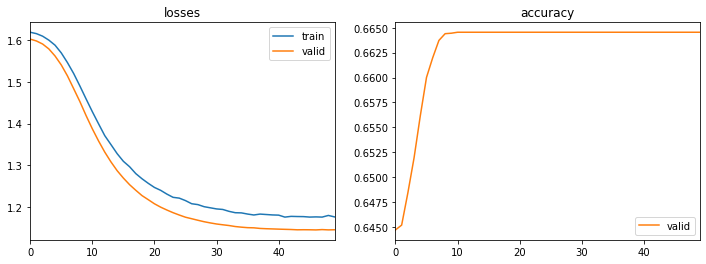

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': False, 'conv_layers': (64, 128, 64), 'epochs': 10, 'hidden_size': 50, 'kss': (9, 7, 5), 'lr': 0.0001, 'optimizer': <function SGD at 0x00000188DE20C0D8>, 'patience': 5, 'rnn_layers': 3, 'time_steps': 90}
GRU_FCN                                                                                                                
 73%|█████████████████████████████████            | 22/30 [1:12:51<31:46, 238.30s/trial, best loss: 0.8449867367744446]

epoch,train_loss,valid_loss,accuracy,time
0,1.750189,1.711668,0.279571,00:05
1,1.666179,1.621350,0.486173,00:05
2,1.556603,1.504545,0.650982,00:05
3,1.478810,1.422329,0.664543,00:05
4,1.419067,1.359867,0.664543,00:05
5,1.376308,1.328146,0.664543,00:05
6,1.356397,1.303961,0.664543,00:05
7,1.341294,1.293533,0.664543,00:05
8,1.339479,1.290040,0.664543,00:05
9,1.339137,1.285669,0.664543,00:05


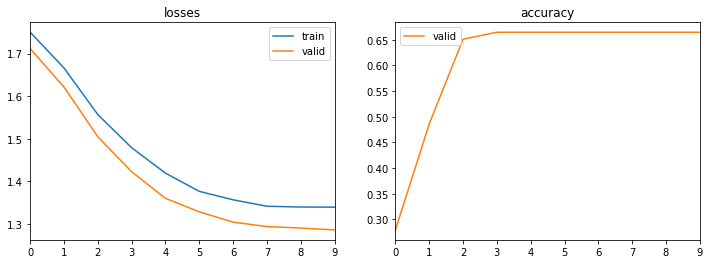

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': False, 'conv_layers': (64, 128, 64), 'epochs': 50, 'hidden_size': 50, 'kss': (9, 7, 5), 'lr': 0.0001, 'optimizer': <function RMSProp at 0x00000188DE20C1F8>, 'patience': 10, 'rnn_layers': 3, 'time_steps': 90}
GRU_FCN                                                                                                                
 77%|██████████████████████████████████▌          | 23/30 [1:14:08<22:09, 189.95s/trial, best loss: 0.8449867367744446]

epoch,train_loss,valid_loss,accuracy,time
0,1.634870,1.630333,0.531972,00:05
1,1.461460,1.455635,0.590657,00:05
2,1.206006,1.162987,0.642971,00:05
3,1.051132,1.007181,0.658752,00:05
4,0.983361,0.967430,0.657449,00:05
5,0.932095,0.940851,0.662082,00:05
6,0.901469,0.908415,0.667921,00:05
7,0.876397,0.892879,0.673713,00:05
8,0.854707,0.882989,0.678925,00:05
9,0.836949,0.874621,0.681772,00:05


No improvement since epoch 18: early stopping                                                                          
 77%|██████████████████████████████████▌          | 23/30 [1:16:57<22:09, 189.95s/trial, best loss: 0.8449867367744446]

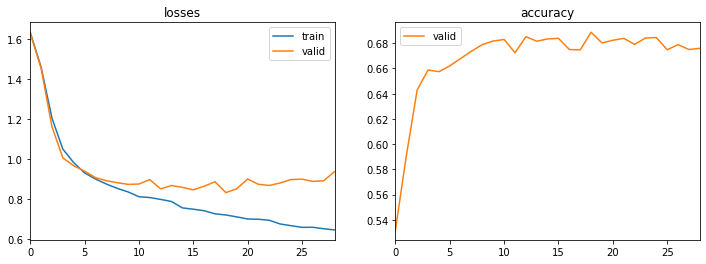

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': False, 'conv_layers': (128, 256, 128), 'epochs': 10, 'hidden_size': 50, 'kss': (9, 7, 5), 'lr': 0.0001, 'optimizer': <function SGD at 0x00000188DE20C0D8>, 'patience': 10, 'rnn_layers': 3, 'time_steps': 90}
GRU_FCN                                                                                                                
 80%|████████████████████████████████████         | 24/30 [1:17:23<19:09, 191.57s/trial, best loss: 0.8449867367744446]

epoch,train_loss,valid_loss,accuracy,time
0,1.810543,1.796884,0.140775,00:08
1,1.658826,1.622019,0.210897,00:08
2,1.470989,1.434250,0.656001,00:08
3,1.348130,1.316187,0.662516,00:08
4,1.282995,1.248630,0.664447,00:08
5,1.244449,1.210509,0.664495,00:08
6,1.226121,1.190420,0.664543,00:08
7,1.210527,1.182385,0.664543,00:08
8,1.207004,1.179136,0.664543,00:08
9,1.214082,1.176646,0.664543,00:08


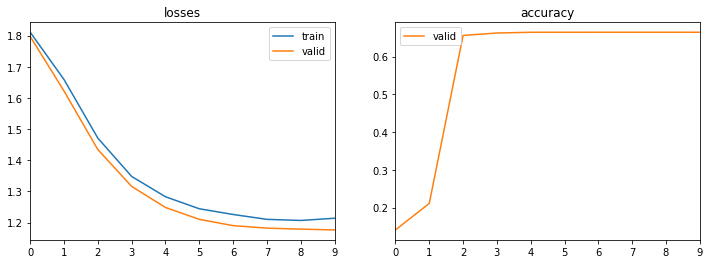

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': False, 'conv_layers': (128, 256, 128), 'epochs': 10, 'hidden_size': 200, 'kss': (9, 7, 5), 'lr': 0.1, 'optimizer': <function SGD at 0x00000188DE20C0D8>, 'patience': 5, 'rnn_layers': 3, 'time_steps': 90}
GRU_FCN                                                                                                                
 83%|█████████████████████████████████████▌       | 25/30 [1:19:11<13:52, 166.44s/trial, best loss: 0.8449867367744446]

epoch,train_loss,valid_loss,accuracy,time
0,1.130585,1.063718,0.662999,00:08
1,0.977864,0.957066,0.653636,00:08
2,0.919266,0.913130,0.665412,00:08
3,0.895315,0.884641,0.671010,00:08
4,0.880178,0.905733,0.670383,00:09
5,0.865269,0.854323,0.680083,00:09
6,0.854825,0.847860,0.683703,00:09
7,0.842683,0.853800,0.682351,00:09
8,0.840209,0.850931,0.683992,00:09
9,0.840447,0.853379,0.682834,00:09


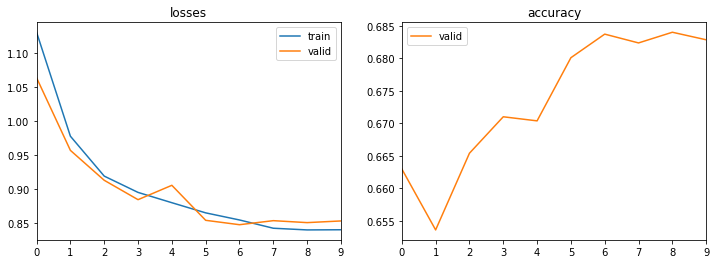

Trying params:                                                                                                         
{'batch_size': 512, 'bidirectional': False, 'conv_layers': (64, 128, 64), 'epochs': 50, 'hidden_size': 50, 'kss': (9, 7, 5), 'lr': 0.1, 'optimizer': <function RMSProp at 0x00000188DE20C1F8>, 'patience': 10, 'rnn_layers': 5, 'time_steps': 60}
GRU_FCN                                                                                                                
 87%|███████████████████████████████████████      | 26/30 [1:21:06<10:04, 151.20s/trial, best loss: 0.8449867367744446]

epoch,train_loss,valid_loss,accuracy,time
0,0.906965,0.863814,0.680710,00:04
1,0.879986,0.949374,0.679311,00:04
2,0.865143,0.937761,0.676415,00:04
3,0.835207,1.055562,0.657883,00:04
4,0.809189,1.100569,0.673230,00:04
5,0.800937,0.976599,0.670769,00:04
6,0.799663,1.165060,0.587375,00:04
7,0.763063,1.047415,0.658945,00:04
8,0.732821,1.176506,0.671203,00:04
9,0.711019,1.408146,0.666763,00:04


No improvement since epoch 0: early stopping                                                                           
 87%|███████████████████████████████████████      | 26/30 [1:21:51<10:04, 151.20s/trial, best loss: 0.8449867367744446]

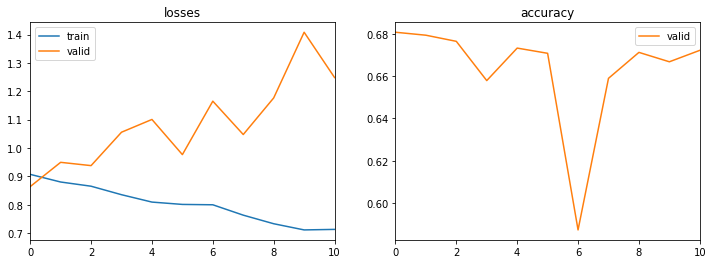

Trying params:                                                                                                         
{'batch_size': 512, 'bidirectional': False, 'conv_layers': (128, 256, 128), 'epochs': 50, 'hidden_size': 50, 'kss': (7, 5, 3), 'lr': 0.0001, 'optimizer': <function RMSProp at 0x00000188DE20C1F8>, 'patience': 5, 'rnn_layers': 4, 'time_steps': 90}
GRU_FCN                                                                                                                
 90%|████████████████████████████████████████▌    | 27/30 [1:22:17<06:21, 127.04s/trial, best loss: 0.8449867367744446]

epoch,train_loss,valid_loss,accuracy,time
0,1.602422,1.601739,0.567685,00:06
1,1.460127,1.458247,0.579412,00:06
2,1.270757,1.244982,0.613291,00:06
3,1.079725,1.027951,0.649341,00:06
4,0.989811,0.971749,0.655132,00:06
5,0.947407,0.936450,0.665122,00:06
6,0.910505,0.917589,0.669900,00:06
7,0.886820,0.893308,0.674823,00:06
8,0.861088,0.879971,0.678780,00:06
9,0.843560,0.869712,0.680421,00:06


No improvement since epoch 13: early stopping                                                                          
 90%|████████████████████████████████████████▌    | 27/30 [1:24:17<06:21, 127.04s/trial, best loss: 0.8449867367744446]

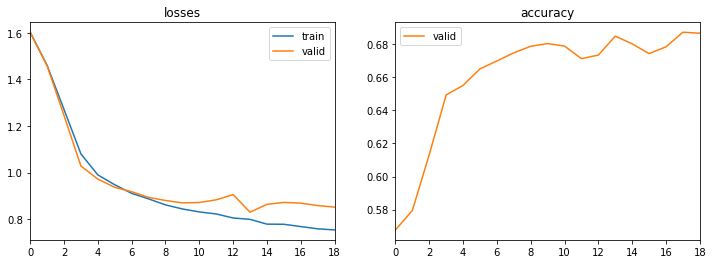

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': False, 'conv_layers': (64, 128, 64), 'epochs': 10, 'hidden_size': 200, 'kss': (9, 7, 5), 'lr': 0.1, 'optimizer': <function SGD at 0x00000188DE20C0D8>, 'patience': 5, 'rnn_layers': 3, 'time_steps': 30}
GRU_FCN                                                                                                                
 93%|██████████████████████████████████████████   | 28/30 [1:24:43<04:25, 132.69s/trial, best loss: 0.8449867367744446]

epoch,train_loss,valid_loss,accuracy,time
0,1.012869,1.010563,0.659572,00:05
1,0.945040,0.972668,0.661648,00:05
2,0.922772,1.001229,0.656822,00:05
3,0.912403,0.935867,0.672651,00:05
4,0.889944,0.937221,0.670865,00:05
5,0.874914,0.955498,0.660393,00:05
6,0.857801,0.915786,0.677863,00:05
7,0.845019,0.916224,0.674871,00:05
8,0.830112,0.915641,0.677670,00:05
9,0.829452,0.920053,0.674967,00:05


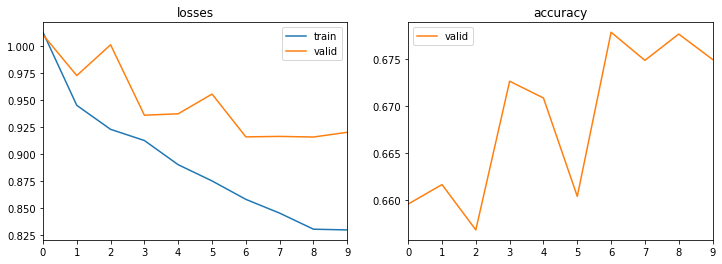

Trying params:                                                                                                         
{'batch_size': 512, 'bidirectional': False, 'conv_layers': (128, 256, 128), 'epochs': 50, 'hidden_size': 50, 'kss': (9, 7, 5), 'lr': 0.0001, 'optimizer': <function RMSProp at 0x00000188DE20C1F8>, 'patience': 10, 'rnn_layers': 3, 'time_steps': 90}
GRU_FCN                                                                                                                
 97%|███████████████████████████████████████████▌ | 29/30 [1:26:01<01:56, 116.39s/trial, best loss: 0.8449867367744446]

epoch,train_loss,valid_loss,accuracy,time
0,1.789979,1.819803,0.412142,00:07
1,1.614974,1.678085,0.529656,00:07
2,1.405257,1.404706,0.595193,00:07
3,1.155844,1.110451,0.640606,00:07
4,1.009864,0.984078,0.657739,00:07
5,0.954183,0.930906,0.666763,00:07
6,0.915909,0.915696,0.674340,00:07
7,0.876637,0.898746,0.681000,00:07
8,0.849932,0.862540,0.685150,00:07
9,0.828868,0.832774,0.687805,00:07


No improvement since epoch 13: early stopping                                                                          
 97%|███████████████████████████████████████████▌ | 29/30 [1:28:58<01:56, 116.39s/trial, best loss: 0.8449867367744446]

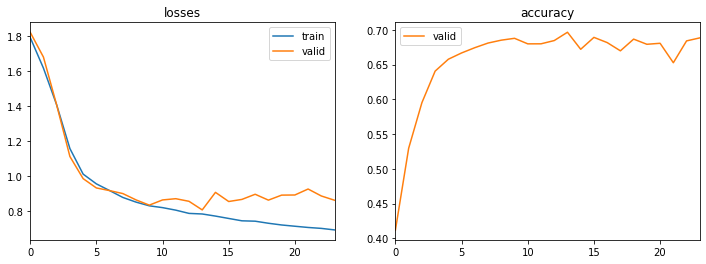

100%|█████████████████████████████████████████████| 30/30 [1:28:59<00:00, 177.97s/trial, best loss: 0.8449867367744446]


In [34]:
trials = Trials()
best = fmin(create_model_hypopt,
    space=search_space,
    algo=tpe.suggest,
    max_evals=30,  # test trials
    trials=trials)

In [35]:
print(best)

{'bidirectional': 1, 'bs': 0, 'conv_layers': 0, 'epochs': 0, 'hidden_size': 0, 'kss': 1, 'lr': 0, 'optimizer': 1, 'patience': 1, 'rnn_layers': 1, 'ts': 2}


In [36]:
from hyperopt import space_eval

In [37]:
print("Best parameters:")
print(space_eval(search_space, best))

Best parameters:
{'batch_size': 256, 'bidirectional': False, 'conv_layers': (64, 128, 64), 'epochs': 10, 'hidden_size': 50, 'kss': (9, 7, 5), 'lr': 0.1, 'optimizer': <function SGD at 0x00000188DE20C0D8>, 'patience': 10, 'rnn_layers': 2, 'time_steps': 90}


In [38]:
best_parameters = space_eval(search_space, best)

In [39]:
def build_model(params):
    # clear memory 
    gc.collect()
    print("Trying params:",params)
    batch_size = params["batch_size"]
    time_steps = params["time_steps"]
    
    # Create data loader
    tfms  = [None, [Categorize()]]
    dsets = TSDatasets(X[:, :, -time_steps:], y, tfms=tfms, splits=splits, inplace=True)
    # set num_workers for memory bottleneck
    dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)
    
    # Create model
    arch = GRU_FCN
    k = {
        'rnn_layers': params['rnn_layers'],
        'hidden_size': params['hidden_size'],
        'bidirectional': params['bidirectional'],
        'conv_layers': params['conv_layers'],
        'kss': params['kss']
    }
    model = create_model(arch, dls=dls, **k)
    print(model.__class__.__name__)
    
    # Training the model
    learn = Learner(dls, model, metrics=accuracy, opt_func=params['optimizer'])
    start = time.time()
    learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                        cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
    learn.plot_metrics()
    elapsed = time.time() - start
    
    # delete tmp variables
    del dls
    del model
    return learn

Trying params: {'batch_size': 256, 'bidirectional': False, 'conv_layers': (64, 128, 64), 'epochs': 10, 'hidden_size': 50, 'kss': (9, 7, 5), 'lr': 0.1, 'optimizer': <function SGD at 0x00000188DE20C0D8>, 'patience': 10, 'rnn_layers': 2, 'time_steps': 90}
GRU_FCN


epoch,train_loss,valid_loss,accuracy,time
0,0.994186,0.968848,0.654602,00:04
1,0.907549,0.918931,0.669273,00:04
2,0.866325,0.931963,0.660972,00:04
3,0.853640,0.900413,0.659090,00:04
4,0.826828,0.817982,0.689252,00:04
5,0.796646,0.895319,0.662999,00:04
6,0.785269,0.820121,0.686212,00:04
7,0.770767,0.858683,0.679118,00:04
8,0.759964,0.833025,0.688480,00:04
9,0.757997,0.836461,0.685536,00:04


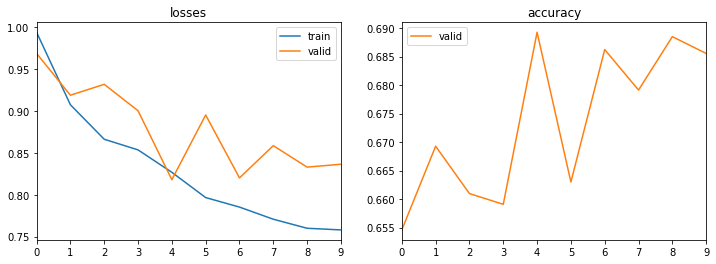

In [40]:
learn = build_model(best_parameters)

In [41]:
dls = learn.dls
valid_dl = dls.valid

In [42]:
time_steps = best_parameters["time_steps"]
X_test_tmp = X_test[:, :, -time_steps:]

In [43]:
test_ds = valid_dl.dataset.add_test(X_test_tmp, y_test)  # use the test data
test_dl = valid_dl.new(test_ds)
print(test_dl.n)

102430


In [44]:
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
test_probas, test_targets, test_preds

(tensor([[7.7575e-01, 1.4347e-01, 5.4585e-02, 2.2215e-02, 3.5933e-03, 3.8683e-04],
         [9.6031e-01, 3.1268e-02, 7.4526e-03, 8.6821e-04, 8.1236e-05, 2.3053e-05],
         [9.9305e-01, 6.2443e-03, 6.5033e-04, 5.5220e-05, 3.5003e-06, 4.3139e-07],
         ...,
         [9.9308e-01, 6.3963e-03, 4.4783e-04, 6.6676e-05, 4.2829e-06, 1.9275e-06],
         [9.8870e-01, 9.8643e-03, 1.1155e-03, 2.8254e-04, 2.8513e-05, 8.2569e-06],
         [8.9008e-01, 8.9486e-02, 1.7275e-02, 2.7575e-03, 3.4829e-04, 5.6394e-05]]),
 TensorCategory([1, 0, 0,  ..., 0, 0, 0], dtype=torch.int32),
 tensor([0, 0, 0,  ..., 0, 0, 0]))

In [45]:
print(f'accuracy: {skm.accuracy_score(test_targets, test_preds):10.6f}')
print(f'f1 score: {skm.f1_score(test_targets, test_preds, average="weighted"):10.6f}')

accuracy:   0.720658
f1 score:   0.691501


Save the true and predicted results:

In [46]:
y_test_true = test_targets.numpy()
y_test_pred = test_preds.numpy()

In [47]:
np.save('y_true_GRU_FCN', y_test_true)
np.save('y_pred_GRU_FCN', y_test_pred)